<a href="https://colab.research.google.com/github/dinachawla/Delay_Match_To_Category/blob/main/DelayMatchToCategory_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x
# Install gym
! pip install gym
# Install neurogym
! git clone https://github.com/nemyers/neurogym
%cd neurogym/
! pip install -e .
# Install stable-baselines
! pip install --upgrade stable-baselines
! pip install tabulate

TensorFlow 1.x selected.
Cloning into 'neurogym'...
remote: Enumerating objects: 10747, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10747 (delta 3), reused 0 (delta 0), pack-reused 10737
Receiving objects: 100% (10747/10747), 8.11 MiB | 13.53 MiB/s, done.
Resolving deltas: 100% (8127/8127), done.
/content/neurogym
Obtaining file:///content/neurogym
  Running setup.py develop for neurogym
     |████████████████████████████████| 240 kB 33.0 MB/s 
  Attempting uninstall: stable-baselines
    Found existing installation: stable-baselines 2.2.1
    Uninstalling stable-baselines-2.2.1:
      Successfully uninstalled stable-baselines-2.2.1


In [ ]:
# SETUP PATH
#general
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import os

#for tables
from tabulate import tabulate

In [ ]:
#for task definition
import neurogym as ngym
import gym

#for torch
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import torch.optim as optim

#for analysis
from sklearn.decomposition import PCA

In [ ]:
# Environment
task = 'DelayMatchCategoryMod-v0'
dim_ring = 32
sigma    = 6
timing   = {'fixation': 200,
            'sample': 650,
            'first_delay': 200,
            #'first_delay': ('choice', [200, 400, 600, 800, 1000]), #Adding noise - delay values (increasing increments), sigma start off with 0, icrease 
            'test': 650 }
kwargs = {'dt': 50, 'timing': timing, 'dim_ring': dim_ring,'sigma': sigma, 'stim_range': 1.00}
seq_len = 50

# Make supervised dataset
dataset = ngym.Dataset(task,env_kwargs=kwargs, batch_size=20, seq_len=seq_len)

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


(50, 20, 33)
(50, 20)


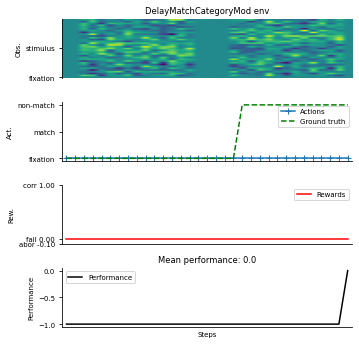

In [ ]:
# A sample environment from dataset
env = dataset.env
# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=1, def_act=0)

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

############
# check task
inputs, target = dataset()
#plt.Figure()
#plt.plot(inputs[110,19,0:33])
mask = target > 0
print(inputs.shape)   # (N_time, batch_size, N_neuron)
print(target.shape)   # (N_time, batch_size)

In [ ]:
# define net
class CTRNN(nn.Module):
    """Continuous-time RNN.

    Args:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: (seq_len, batch, input_size), network input
        hidden: (batch, hidden_size), initial hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Recurrence helper."""
        pre_activation = self.input2h(input) + self.h2h(hidden)
        h_new = torch.tanh(hidden * self.oneminusalpha +
                           pre_activation * self.alpha)
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        output = torch.stack(output, dim=0)
        return output, hidden


class RNNNet(nn.Module):
    """Recurrent network model.

    Args:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
        rnn: str, type of RNN, lstm, rnn, ctrnn, or eirnn
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Continuous time RNN
        self.rnn = CTRNN(input_size, hidden_size, **kwargs)
        self.fc  = nn.Linear(hidden_size, output_size)
        
    def readout(fc_state):
        """output helper."""
        h_out = 0.5*torch.tanh(fc_state-3.0)
        return h_out

    def forward(self, x):
        rnn_activity, _ = self.rnn(x)
        out = self.fc(rnn_activity)
        #out = self.readout(out)
        return out, rnn_activity

In [ ]:
# Train net
# Reset Network
# Instantiate the network and print information
hidden_size =150
net = RNNNet(input_size=input_size, hidden_size=hidden_size,
             output_size=output_size, dt=env.dt)
print(net)

RNNNet(
  (rnn): CTRNN(
    (input2h): Linear(in_features=33, out_features=150, bias=True)
    (h2h): Linear(in_features=150, out_features=150, bias=True)
  )
  (fc): Linear(in_features=150, out_features=3, bias=True)
)


In [ ]:
#adding for loop here that modifies task parameters
delay_list  = [200, 400, 600, 800, 1000]
sigma_range = [0, 0.05, 0.1, 0.2, 0.4, 0.8, 1.6, 2.4]
variable_list = []

cur_delay = 200

# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

#for cur_sigma in sigma_range:
for cur_delay in delay_list: #loop over delays
    # Make supervised dataset
    sigma    = 6
    variable_list.append(cur_delay)
    print(variable_list)
    timing   = {'fixation': 200,
                'sample': 650,
                #'first_delay': cur_delay,
                'first_delay': ('choice', variable_list), #Adding noise - delay values (increasing increments), sigma start off with 0, icrease 
                'test': 650 }
    kwargs = {'dt': 50, 'timing': timing, 'dim_ring': dim_ring,'sigma': sigma, 'stim_range': 1.00}
    seq_len = 50
    dataset = ngym.Dataset(task,env_kwargs=kwargs, batch_size=20, seq_len=seq_len)

    # train net
    running_loss = 0
    running_acc = 0
    for i in range(50000):
        inputs, labels_np = dataset()
        labels_np = labels_np.flatten()
        inputs = torch.from_numpy(inputs).type(torch.float)
        labels = torch.from_numpy(labels_np).type(torch.long)
        
        
        y_onehot = torch.FloatTensor(labels.size(0), output_size)
        y_onehot[:,:]=0

        labelnum = np.arange(output_size)
        
        for  ilabel, y in enumerate(labelnum):
            batch_idx = labels_np==y
            #y_onehot.zero_()
            #y_onehot.scatter_(1, y, 1)
            #y_onehot[batch_idx,:]=0
            y_onehot[batch_idx,y]=1
            
        # in your training loop:
        optimizer.zero_grad()   # zero the gradient buffers
        output, _ = net(inputs)
        output = output.view(-1, output_size)
        #loss = criterion(output, labels)
        loss = criterion(output,y_onehot)
        #loss = criterion(output[320:,:], labels[320:,])
        
        loss.backward()
        optimizer.step()    # Does the update

        running_loss += loss.item()
        # Compute performance
        output_np = np.argmax(output.detach().numpy(), axis=-1)
        ind = labels_np > 0  # Only analyze time points when target is not fixation
        running_acc += np.mean(labels_np[ind] == output_np[ind])
        if i % 100 == 99:
            running_loss /= 100
            running_acc /= 100
            print('Delay: ',cur_delay,' Step {}, Loss {:0.4f}, Acc {:0.3f}'.format(i+1, running_loss, running_acc))
            
            if running_acc >= 0.87:
              break
            running_loss = 0
            running_acc = 0

       

[200]
Delay:  200  Step 100, Loss 0.1807, Acc 0.025
Delay:  200  Step 200, Loss 0.1289, Acc 0.223
Delay:  200  Step 300, Loss 0.0911, Acc 0.410
Delay:  200  Step 400, Loss 0.0822, Acc 0.474
Delay:  200  Step 500, Loss 0.0775, Acc 0.485
Delay:  200  Step 600, Loss 0.0751, Acc 0.503
Delay:  200  Step 700, Loss 0.0728, Acc 0.548
Delay:  200  Step 800, Loss 0.0670, Acc 0.735
Delay:  200  Step 900, Loss 0.0552, Acc 0.828
Delay:  200  Step 1000, Loss 0.0418, Acc 0.883
[200, 400]
Delay:  400  Step 100, Loss 0.0374, Acc 0.875
[200, 400, 600]
Delay:  600  Step 100, Loss 0.0298, Acc 0.891
[200, 400, 600, 800]
Delay:  800  Step 100, Loss 0.0268, Acc 0.884
[200, 400, 600, 800, 1000]
Delay:  1000  Step 100, Loss 0.0262, Acc 0.888


In [ ]:
delay_list  = [200, 400, 600, 800, 1000]
sigma_range = [0, 0.5, 1, 2, 3, 4, 5, 6]
cur_delay = 200
cur_sigma = 0


for cur_delay in delay_list:
  for cur_sigma in sigma_range:
    # get sample trials to analyse network activity
    timing   = {'fixation': 200,
                    'sample': 650,
                    #'first_delay': 1000,
                    'first_delay': cur_delay,
                    'test': 650 }
    kwargs = {'timing': timing, 'sigma': cur_sigma, 'stim_range': 1, 'dim_ring': 32,'dt':50}
    env = gym.make(task, **kwargs)
    env.reset(no_step=True)

    perf = 0
    num_trial = 1000
    activity_dict = {}
    trial_infos = {}
    output_dict = {}
    test_acc = np.zeros(num_trial)

    for i in range(num_trial):
        env.new_trial()
        ob, gt = env.ob, env.gt
        inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
        action_pred, rnn_activity = net(inputs)
        rnn_activity = rnn_activity[:, 0, :].detach().numpy()
        
        output = action_pred.view(-1, output_size)
        output_np = np.argmax(output.detach().numpy(), axis=-1)
        ind = gt > 0  # Only analyze time points when target is not fixation
        test_acc[i] = np.mean(gt[ind] == output_np[ind])

        action_pred = action_pred[:, 0, :].detach().numpy()
        activity_dict[i] = rnn_activity[env.start_ind['first_delay']:env.end_ind['test']]
        #activity_dict[i] = rnn_activity[env.start_ind['test']:env.end_ind['test']]
        #output_dict[i] = action_pred[env.start_ind['fixation']:env.end_ind['test']]
        trial_infos[i] = env.trial.copy()

    # Concatenate activity for PCA
    #activity = np.concatenate(list(activity_dict[i] for i in range(num_trial)), axis=0)
    #print('Shape of the neural activity: (Time points, Neurons): ', activity.shape)
    print('Sigma: ',cur_sigma,' Delay: ',cur_delay, 'Test Accuracy: ',np.mean(test_acc))

Sigma:  0  Delay:  200 Test Accuracy:  0.131
Sigma:  0.5  Delay:  200 Test Accuracy:  0.12853846153846155
Sigma:  1  Delay:  200 Test Accuracy:  0.11784615384615384
Sigma:  2  Delay:  200 Test Accuracy:  0.12161538461538461
Sigma:  3  Delay:  200 Test Accuracy:  0.1343846153846154
Sigma:  4  Delay:  200 Test Accuracy:  0.12553846153846154
Sigma:  5  Delay:  200 Test Accuracy:  0.15353846153846154
Sigma:  6  Delay:  200 Test Accuracy:  0.16230769230769232
Sigma:  0  Delay:  400 Test Accuracy:  0.21507692307692308
Sigma:  0.5  Delay:  400 Test Accuracy:  0.20276923076923078
Sigma:  1  Delay:  400 Test Accuracy:  0.20930769230769233
Sigma:  2  Delay:  400 Test Accuracy:  0.1973846153846154
Sigma:  3  Delay:  400 Test Accuracy:  0.1946153846153846
Sigma:  4  Delay:  400 Test Accuracy:  0.2053846153846154
Sigma:  5  Delay:  400 Test Accuracy:  0.23630769230769233
Sigma:  6  Delay:  400 Test Accuracy:  0.22192307692307692
Sigma:  0  Delay:  600 Test Accuracy:  0.5285384615384614
Sigma:  0.5 

KeyboardInterrupt: ignored

In [ ]:
net.parameters

<bound method Module.parameters of RNNNet(
  (rnn): CTRNN(
    (input2h): Linear(in_features=33, out_features=150, bias=True)
    (h2h): Linear(in_features=150, out_features=150, bias=True)
  )
  (fc): Linear(in_features=150, out_features=3, bias=True)
)>

In [ ]:
# Compute PCA (principal component analysis) and visualize
npcs = 2
pca = PCA(n_components=npcs)
pca.fit(activity)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(6, 3))
for i in range(num_trial):
    trial = trial_infos[i]
    activity_pc = pca.transform(activity_dict[i])
    
    color = 'red' if trial['ground_truth'] == 1 else 'blue'
    
    _ = ax1.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color)
    
    if i < 1:
        _ = ax2.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color)

ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')

NameError: ignored

In [ ]:
# Compute PCA and visualize
npcs = 2
pca = PCA(n_components=npcs)
pca.fit(activity)
# print('Shape of the projected activity: (Time points, PCs): ', activity_pc.shape)
if npcs == 2:
    fig, (ax1) = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(6, 3))
else:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(6, 3))
for i in range(num_trial):
    trial = trial_infos[i]
    activity_pc = pca.transform(activity_dict[i])
    
    color = 'red' 
    cmap = mpl.cm.get_cmap('winter')
    cmap1 = mpl.cm.get_cmap('summer')
    if   trial['sample_category'] == 1 and trial['ground_truth']=='match':
        color = 'red'
        color = cmap(1/4)
    elif trial['sample_category'] == 1 and trial['ground_truth']=='non-match':
        color = cmap(2/4)
    elif trial['sample_category'] == 0 and trial['ground_truth']=='match':
        color = 'green' 
        color = cmap1(1/4)
    elif trial['sample_category'] == 0 and trial['ground_truth']=='non-match':
        color= 'blue'
        color = cmap1(2/4)
    
    _ = ax1.plot(activity_pc[:, 0], activity_pc[:,1], 'o-', color=color)
    
    if npcs > 2:
        _ = ax2.plot(activity_pc[:, 0], activity_pc[:, 2], 'o-', color=color)
        _ = ax3.plot(activity_pc[:, 1], activity_pc[:, 2], 'o-', color=color)
        

ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')

ax2.set_xlabel('PC 1')
ax2.set_ylabel('PC 3')

ax3.set_xlabel('PC 2')
ax3.set_ylabel('PC 3')

# Convert information into pandas dataframe
df = pd.DataFrame()
for i in range(len(trial_infos)):
    df = df.append(trial_infos[i], ignore_index=True)
    

trials = df[df['ground_truth']=='match'].index
output_match = np.mean(np.array([output_dict[i] for i in trials]), axis=0)

trials = df[df['ground_truth']=='non-match'].index
output_nomatch = np.mean(np.array([output_dict[i] for i in trials]), axis=0)

NameError: ignored